# Model Building 
# using Review Length , Polarity and Subjectivity

## EDA extended - Hotels Rating classification -

In [ ]:
# Summary of this file

1. We have done EDA   
contractions replaced ( replacing n't  and 'nt  by not)   
removing word 'not' from list of stopwords

2. Length of original reviews and Length of clean_reviews   
Have run different models   
Logistic Regression, KNN, Decision Trees, Gaussian Naive Bayes, Multinomial  Naive Bayes   
accuracy and f1-macro-scores were very poor

3. Sentiments using TextBlob - polarity and subjectivity   
Have run models using both as well as separately, poor accuracy and f1-macro-scores 
for subjectivity scores were still lesser as compared to that of polarity  

4. We have also run Random forest and SVM on polarity, but poor results

5. cross-validation with number of folds (10)    
Since data is imbalanced , we have run using  cross-validation and found out f1-macro-scores
for all. 

6. The results (accuracy and f1-macro scores)  have been very poor,   
when we run various models using length and sentiments of reviews (original and cleaned)   

Previously we have run various models on tf-binary, tf and tfidf    
Next we will run models combining those term-vectors with length and sentiments and check the results


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [101]:
# Importing Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, roc_auc_score,f1_score

In [102]:
# Importing libraries for running different models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier


In [3]:
# Libraries for text preprocessing
import re
import nltk

#nltk.download('stopwords')
from nltk.corpus import stopwords # import stopwords 

#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer # to lemmatize the words

from nltk.tokenize import RegexpTokenizer, word_tokenize # to tokenize sentences into words

from collections import Counter

In [4]:
data = pd.read_csv("E:\\1 P36 PROJECT\\Original Datasets\\train (2).csv")

In [5]:
data.shape
data.head(3)
data.tail(3)

(14343, 3)

ID                                             Review  Rating
0   0  exceptional service nice all-around daughter s...       5
1   1  beautiful relaxing jw marriott desert ridge re...       5
2   2  great location great location 5 mins subway ta...       5

ID                                             Review  Rating
14340  14340  great place relax know looking vacation book t...       4
14341  14341  better just got week seattle loved minute, pac...       3
14342  14342  stay clear, internet reservation friday rang h...       1

In [6]:
# DUPLICATE REVIEWS 
new_Reviews = list(set(data.Review)) # removes duplicate reviews
len(new_Reviews) # 14343
# no review has been duplicated

14343

In [7]:
# Finding missing values
data.isnull().sum()

ID        0
Review    0
Rating    0
dtype: int64

In [8]:
# finding length of the reviews
data['Length_Review'] = data['Review'].apply(len)
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

   Length_Review  
0            937  
1            791  
2            473

### Finding count of words in original Review

In [9]:
# Finding count of words in original Review
# from collections import Counter
text = data['Review'].str.lower()

word_counts_review = Counter(word_tokenize('\n'.join(text)))

word_counts_review.most_common(20) # ('not', 22067)

[(',', 173610),
 ('hotel', 34073),
 ('room', 23883),
 ('not', 22067),
 ('great', 14927),
 ("n't", 13373),
 ('good', 11916),
 ('staff', 11343),
 ('stay', 10559),
 ('did', 9679),
 ('just', 8839),
 ('nice', 8681),
 ('rooms', 8441),
 ('no', 8067),
 ('location', 7744),
 ('stayed', 7394),
 ('time', 6996),
 ('service', 6991),
 ('beach', 6858),
 ('night', 6689)]

In [10]:
# Replacing contractions (shorter vesions of words) with full word (n't , 'nt  as not)
for index, row in data.iterrows():
    phrase = row['Review']
    phrase = phrase.lower() #Convert to lowercase
    phrase = re.sub(r"n\'t", " not", phrase) # replace n't  with not
    phrase = re.sub(r"\'nt", " not", phrase) # replace 'nt  with not 
    data.at[index, 'Review_2'] = phrase
data[0:3]

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

   Length_Review                                           Review_2  
0            937  exceptional service nice all-around daughter s...  
1            791  beautiful relaxing jw marriott desert ridge re...  
2            473  great location great location 5 mins subway ta...

### Finding count of words in Review_2

In [11]:
# Finding count of words in Review_2
text = data['Review_2'].str.lower()

word_counts_review2 = Counter(word_tokenize('\n'.join(text)))

word_counts_review2.most_common(5) # ('not', 35479),



[(',', 173610),
 ('not', 35479),
 ('hotel', 34073),
 ('room', 23883),
 ('great', 14927)]

TEXT NORMALIZATION
converting all letters to lower case
removing numbers
removing punctuations, accent marks and other diacritics
removing white spaces
removing stop words, sparse terms, and particular words

### Removing word "not" from stopwords list and Cleaning the text 

In [12]:

# TEXT NORMALIZATION   or PRE-PROCESSING

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english")) -set(["not"])
##Creating a list of custom stopwords
new_words = ['n',"th","hotel",'hotels','room','rooms','restaurant','restaurants','e','ca','nd','wo','el','etc']
stop_words = stop_words.union(new_words)

for index, row in data.iterrows():
    text = re.sub('[^a-zA-Z]', ' ', row['Review_2']) # Remove punctuations    
    # text = text.lower() #Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)  # remove tags
    text = re.sub("(\\d|\\W)+"," ",text)  # remove special characters and digits
    text = text.split()  # Convert to list from string
    
    #Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if not word  in stop_words] 
    text_string = " ".join(text)
    data.at[index, 'Clean_review'] = text_string
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

   Length_Review                                           Review_2  \
0            937  exceptional service nice all-around daughter s...   
1            791  beautiful relaxing jw marriott desert ridge re...   
2            473  great location great location 5 mins subway ta...   

                                        Clean_review  
0  exceptional service nice around daughter staye...  
1  beautiful relaxing jw marriott desert ridge re...  
2  great location great location min subway take ...

In [13]:
# Finding total words in Cleaned review
clean_review_list = " ".join(data['Clean_review'])
clean_review_list = clean_review_list.split()
len(clean_review_list)# 1368889 words are present  
 
# 13,68,889 words are present in cleaned reviews (includes duplicate words as well)

1368889

In [14]:
# Now we will be using Clean_review 

# finding frequency of all words 

words_all = len(clean_review_list)
words_all # 1368889

word_dist = nltk.FreqDist(clean_review_list)

freq_data_all = pd.DataFrame(word_dist.most_common(words_all), columns=['Word','Frequency'])

freq_data_all['percentFreq_all'] =(freq_data_all.Frequency / freq_data_all.Frequency.sum())*100 
freq_data_all['percentFreq_unique'] =(freq_data_all.Frequency / len(freq_data_all))*100 

len(freq_data_all) # 37558
freq_data_all[0:10]

words_all_1= freq_data_all.Frequency.sum() 
words_all_1 # 1368889

# word "not" has not been removed from our list 
# we have total 13,68,889 words
# we have 37,558 unique words  


1368889

37558

Word  Frequency  percentFreq_all  percentFreq_unique
0       not      35612         2.601526           94.818680
1     great      15197         1.110170           40.462751
2      good      12287         0.897589           32.714735
3     staff      11700         0.854708           31.151819
4      stay      10885         0.795170           28.981841
5     night      10326         0.754334           27.493477
6       day       9586         0.700276           25.523191
7      time       9208         0.672662           24.516747
8      nice       8837         0.645560           23.528942
9  location       8139         0.594570           21.670483

1368889

In [15]:
data['Length_Clean_review'] = data['Clean_review'].apply(len)
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

   Length_Review                                           Review_2  \
0            937  exceptional service nice all-around daughter s...   
1            791  beautiful relaxing jw marriott desert ridge re...   
2            473  great location great location 5 mins subway ta...   

                                        Clean_review  Length_Clean_review  
0  exceptional service nice around daughter staye...                  843  
1  beautiful relaxing jw marriott desert ridge re...                  715  
2  great location great location min subway take ...                  410

In [16]:
data_new = data.copy()
data_new.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

   Length_Review                                           Review_2  \
0            937  exceptional service nice all-around daughter s...   
1            791  beautiful relaxing jw marriott desert ridge re...   
2            473  great location great location 5 mins subway ta...   

                                        Clean_review  Length_Clean_review  
0  exceptional service nice around daughter staye...                  843  
1  beautiful relaxing jw marriott desert ridge re...                  715  
2  great location great location min subway take ...                  410

In [17]:
# Removing the intermediate processed reviews from our main dataset
data.columns
data.drop(['Review_2'], axis=1,inplace=True)
data.head(3)

Index(['ID', 'Review', 'Rating', 'Length_Review', 'Review_2', 'Clean_review',
       'Length_Clean_review'],
      dtype='object')

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

   Length_Review                                       Clean_review  \
0            937  exceptional service nice around daughter staye...   
1            791  beautiful relaxing jw marriott desert ridge re...   
2            473  great location great location min subway take ...   

   Length_Clean_review  
0                  843  
1                  715  
2                  410

In [18]:
# viewing first few columns and data types
data.shape
data[0:5]
data.info()

(14343, 6)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   
3   3  pleased nice safe hotel, flower market hotel v...       3   
4   4  excellent hotel service great hotel excellent ...       4   

   Length_Review                                       Clean_review  \
0            937  exceptional service nice around daughter staye...   
1            791  beautiful relaxing jw marriott desert ridge re...   
2            473  great location great location min subway take ...   
3            342  pleased nice safe flower market vast array mai...   
4            244  excellent service great excellent location cou...   

   Length_Clean_review  
0                  843  
1                  715  
2                  410  
3                  275  
4                  207

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14343 entries, 0 to 14342
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   14343 non-null  int64 
 1   Review               14343 non-null  object
 2   Rating               14343 non-null  int64 
 3   Length_Review        14343 non-null  int64 
 4   Clean_review         14343 non-null  object
 5   Length_Clean_review  14343 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 672.5+ KB


### Frequency and Proportion of Ratings category

In [20]:
countRating = data['Rating'].value_counts()
percentRating = np.round(data.Rating.value_counts(normalize=True)*100,2)
Rating_df = pd.DataFrame(list(zip(countRating, percentRating)), columns=["countRating","percentRating"],index=[5,4,3,2,1])
Rating_df

countRating  percentRating
5         6436          44.87
4         4172          29.09
3         1510          10.53
2         1248           8.70
1          977           6.81

### Boxplot - Frequency of Ratings

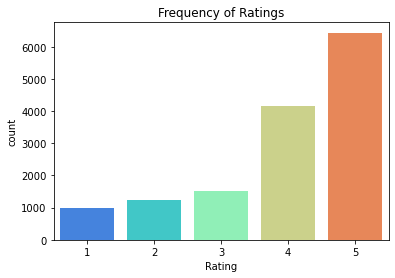

In [21]:
sns.countplot(x='Rating',data=data , palette='rainbow').set_title("Frequency of Ratings");

### Length of Reviews (number of letters)

In [198]:
# Find max, min , mean 
# find max and min of length of original Reviews 
print("Length of original reviews")
data.Length_Review.max() # the largest review has  13501 letters
data.Length_Review.min() # the smallest review has 44 letters
data.Length_Review.mean()
data.Length_Review.std()

# find max and min of length of  Cleaned reviews
print("Length of cleaned reviews")
data.Length_Clean_review.max() # the largest review has  12351 letters
data.Length_Clean_review.min() # the smallest review has 25 letters
data.Length_Clean_review.mean()
data.Length_Clean_review.std()

Length of original reviews


13501

44

729.8767342954751

706.6272007510893

Length of cleaned reviews


12351

25

644.3911315624347

632.4424172072662

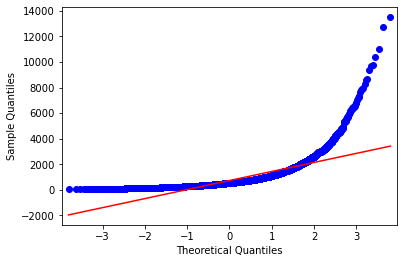

In [23]:
# check normality of original review length
from statsmodels.graphics.gofplots import qqplot
qqplot(data.Length_Review, line='s');

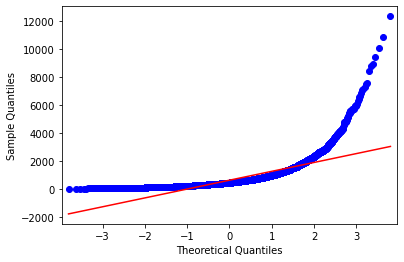

In [24]:
# check normality of cleaned review length

qqplot(data.Length_Clean_review, line='s');

In [25]:
# from above find that both lengths (original and cleaned reviews) are non-normal

## Using TextBlob for obtaining Sentiments

Sentiment analysis is basically the process of determining the attitude or the emotion of the writer, i.e., whether it is positive or negative or neutral.

The sentiment function of textblob returns two properties, polarity, and subjectivity.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 

Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. 

If values are near zero indicates that the sentence is more objective and if values are near one indicates more subjective 
In above 0.7083 subjectivity refers that it is mostly public opinion and not a factual information



In [26]:
# nltk.download('punkt')

from textblob import TextBlob

In [27]:
# Textblob example
blob = TextBlob(" great hotel but room service is bad")
# blob
blob.sentences
blob.noun_phrases
blob.tags

[Sentence(" great hotel but room service is bad")]

WordList(['great hotel', 'room service'])

[('great', 'JJ'),
 ('hotel', 'NN'),
 ('but', 'CC'),
 ('room', 'NN'),
 ('service', 'NN'),
 ('is', 'VBZ'),
 ('bad', 'JJ')]

In [28]:
# Textblob example contd.
blob
blob.sentiment
blob.sentiment_assessments

TextBlob(" great hotel but room service is bad")

Sentiment(polarity=0.0500000000000001, subjectivity=0.7083333333333333)

Sentiment(polarity=0.0500000000000001, subjectivity=0.7083333333333333, assessments=[(['great'], 0.8, 0.75, None), (['bad'], -0.6999999999999998, 0.6666666666666666, None)])

In [29]:
data.head()

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   
3   3  pleased nice safe hotel, flower market hotel v...       3   
4   4  excellent hotel service great hotel excellent ...       4   

   Length_Review                                       Clean_review  \
0            937  exceptional service nice around daughter staye...   
1            791  beautiful relaxing jw marriott desert ridge re...   
2            473  great location great location min subway take ...   
3            342  pleased nice safe flower market vast array mai...   
4            244  excellent service great excellent location cou...   

   Length_Clean_review  
0                  843  
1                  715  
2                  410  
3                  275  
4                  207

In [30]:
data.columns
data_blob = data[["ID","Review","Clean_review","Rating"]]
data_blob.head()

Index(['ID', 'Review', 'Rating', 'Length_Review', 'Clean_review',
       'Length_Clean_review'],
      dtype='object')

ID                                             Review  \
0   0  exceptional service nice all-around daughter s...   
1   1  beautiful relaxing jw marriott desert ridge re...   
2   2  great location great location 5 mins subway ta...   
3   3  pleased nice safe hotel, flower market hotel v...   
4   4  excellent hotel service great hotel excellent ...   

                                        Clean_review  Rating  
0  exceptional service nice around daughter staye...       5  
1  beautiful relaxing jw marriott desert ridge re...       5  
2  great location great location min subway take ...       5  
3  pleased nice safe flower market vast array mai...       3  
4  excellent service great excellent location cou...       4

In [31]:
data_blob[["Polarity_rev", "Subjectivity_rev"]] = data_blob['Review'].apply(lambda Rev: pd.Series(TextBlob(Rev).sentiment))
data_blob.head()

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


ID                                             Review  \
0   0  exceptional service nice all-around daughter s...   
1   1  beautiful relaxing jw marriott desert ridge re...   
2   2  great location great location 5 mins subway ta...   
3   3  pleased nice safe hotel, flower market hotel v...   
4   4  excellent hotel service great hotel excellent ...   

                                        Clean_review  Rating  Polarity_rev  \
0  exceptional service nice around daughter staye...       5      0.375567   
1  beautiful relaxing jw marriott desert ridge re...       5      0.584206   
2  great location great location min subway take ...       5      0.370370   
3  pleased nice safe flower market vast array mai...       3      0.191919   
4  excellent service great excellent location cou...       4      0.553571   

   Subjectivity_rev  
0          0.675850  
1          0.832460  
2          0.535185  
3          0.600379  
4          0.764286

In [32]:
data_blob[["Polarity_cleanRev","Subjectivity_cleanRev"]]= data_blob["Clean_review"].apply(lambda Rev: pd.Series(TextBlob(Rev).sentiment))
data_blob.head()

ID                                             Review  \
0   0  exceptional service nice all-around daughter s...   
1   1  beautiful relaxing jw marriott desert ridge re...   
2   2  great location great location 5 mins subway ta...   
3   3  pleased nice safe hotel, flower market hotel v...   
4   4  excellent hotel service great hotel excellent ...   

                                        Clean_review  Rating  Polarity_rev  \
0  exceptional service nice around daughter staye...       5      0.375567   
1  beautiful relaxing jw marriott desert ridge re...       5      0.584206   
2  great location great location min subway take ...       5      0.370370   
3  pleased nice safe flower market vast array mai...       3      0.191919   
4  excellent service great excellent location cou...       4      0.553571   

   Subjectivity_rev  Polarity_cleanRev  Subjectivity_cleanRev  
0          0.675850           0.377948               0.697279  
1          0.832460           0.584206               0.832460  
2          0.535185           0.392157               0.566667  
3          0.600379           0.191919               0.600379  
4          0.764286           0.590625               0.793750

In [33]:
data_blob[100:105]

ID                                             Review  \
100  100  perfect start honeymoon bride started italian ...   
101  101  warning not stay worst hotel booked did not ro...   
102  102  best best, read reviews thought ok just good p...   
103  103  good not great wife returned night stay, fairl...   
104  104  think twice booking breezes, just got breezes ...   

                                          Clean_review  Rating  Polarity_rev  \
100  perfect start honeymoon bride started italian ...       5      0.546429   
101  warning not stay worst booked not booked said ...       1     -0.280000   
102  best best read review thought ok good place ha...       5      0.533333   
103  good not great wife returned night stay fairly...       3      0.134325   
104  think twice booking breeze got breeze punta ca...       1      0.092168   

     Subjectivity_rev  Polarity_cleanRev  Subjectivity_cleanRev  
100          0.567857           0.546429               0.567857  
101          0.620000          -0.280000               0.620000  
102          0.555556           0.481818               0.539394  
103          0.558896           0.134325               0.558896  
104          0.598214           0.064164               0.608516

from above, on comparing polarity and subjectivity values of original and cleaned reviews there seems to be very less difference


# Model Building

## Using Review Length to Classify the RATINGS

### Creating X and Y and splitting the dataset 

In [39]:
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

   Length_Review                                       Clean_review  \
0            937  exceptional service nice around daughter staye...   
1            791  beautiful relaxing jw marriott desert ridge re...   
2            473  great location great location min subway take ...   

   Length_Clean_review  
0                  843  
1                  715  
2                  410

In [185]:
X1 = data[["Length_Review"]]
X2 = data[["Length_Clean_review"]]
y=data.Rating

X1.shape ; X2.shape ; y.shape
X1.head(3);y.head(3); X2.head(3)

(14343, 1)

(14343, 1)

(14343,)

Length_Review
0            937
1            791
2            473

0    5
1    5
2    5
Name: Rating, dtype: int64

Length_Clean_review
0                  843
1                  715
2                  410

In [186]:
# Splitting into Train and Test data (80:20)

# Length_Review
X_train1,X_test1,y_train1,y_test1 = train_test_split(X1, y, test_size=0.2, stratify=y, random_state=123) 
X_train1.shape ; X_test1.shape

# Length_Clean_review
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2, y, test_size=0.2, stratify=y, random_state=123) 
X_train2.shape ; X_test2.shape

(11474, 1)

(2869, 1)

(11474, 1)

(2869, 1)

## Logistic Regression

###  Logistic Regression on Length of Original Reviews 
### Model on  full Train (X1) data 

Accuracy score : 0.4485114690092728
F1 macro score : 0.1303709605116123
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       977
           2       0.08      0.00      0.00      1248
           3       0.00      0.00      0.00      1510
           4       0.32      0.02      0.03      4172
           5       0.45      0.99      0.62      6436

    accuracy                           0.45     14343
   macro avg       0.17      0.20      0.13     14343
weighted avg       0.30      0.45      0.29     14343



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


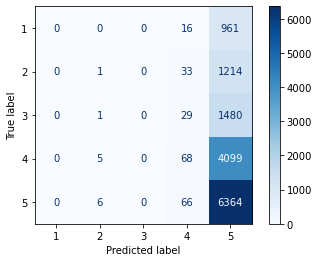

In [189]:
model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X1,y)

# for training data
y_pred_train = model_log.predict(X1)

print("Accuracy score :",accuracy_score(y,y_pred_train))
print("F1 macro score :",f1_score(y,y_pred_train,average="macro"))
print(classification_report(y,y_pred_train))


# plotting confusion matrix
plot_confusion_matrix(model_log, X1,y,cmap=plt.cm.Blues); plt.show();

Poor accuracy and f1-score(macro) . Though in Rating-5, 99% have been correctly classified,
The recall of other ratings is very low (even zero)

###  Logistic Regression - Cross validation on Length_Reviews (full X1 data)
### and Length_clean_review (full X2 data)

In [134]:
# logistic regression on length_rev - full data - cross validation (kfold=10)
kfold = KFold(n_splits=10, shuffle=True)
scoring = "f1_macro"

results_X1 = cross_val_score(LogisticRegression(random_state=123,multi_class='multinomial',
                                             solver='newton-cg'), X1, y, cv=kfold,scoring=scoring)
print("F1-macro score for Length_reviews: %.2f%% (%.2f%%)" % (results_X1.mean()*100, results_X1.std()*100)) 


# logistic regression on length_clean_rev - full data - cross validation (kfold=10)
results_X2 = cross_val_score(LogisticRegression(random_state=123,multi_class='multinomial',
                                             solver='newton-cg'), X2, y, cv=kfold,scoring=scoring)
print("F1-macro score for Length_clean_reviews: %.2f%% (%.2f%%)" % (results_X2.mean()*100, results_X2.std()*100)) 

# F1-macro score for Length_reviews: 13.08% (0.31%)
# F1-macro score for Length_clean_reviews: 12.89% (0.36%)

F1-macro score for Length_reviews: 13.08% (0.31%)
F1-macro score for Length_clean_reviews: 12.89% (0.36%)


Mean f1-macro score is very less for both , only about 13%

### Logistic Regression Model on Length of original Reviews and solver newton-cg
### for train and test data 

Accuracy score : 0.44823078263900995
F1 macro score : 0.1303015701605721
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       782
           2       0.00      0.00      0.00       998
           3       0.00      0.00      0.00      1208
           4       0.31      0.02      0.03      3337
           5       0.45      0.99      0.62      5149

    accuracy                           0.45     11474
   macro avg       0.15      0.20      0.13     11474
weighted avg       0.29      0.45      0.29     11474

Accuracy score : 0.44928546531892644
F1 macro score : 0.12989058274941187
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       302
           4       0.37      0.02      0.03       835
           5       0.45      0.99      0.62      1287

    accuracy                          

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


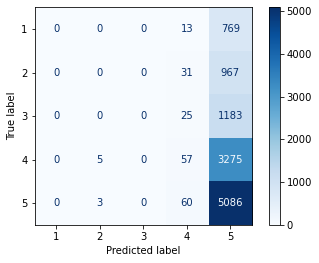

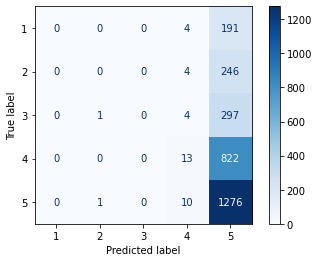

In [190]:
# Logistic regression model
model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X_train1,y_train1)

# for training data
y_pred_train = model_log.predict(X_train1)

print("Accuracy score :" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score :",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))

# for test data 
y_pred_test = model_log.predict(X_test1)

print("Accuracy score :" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score :",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# Plotting confusion matrices for Train and Test 
plot_confusion_matrix(model_log,X_train1,y_train1,cmap=plt.cm.Blues)
plot_confusion_matrix(model_log,X_test1,y_test1,cmap=plt.cm.Blues) ;plt.show();


Model gave very poor results when used only review length (original or cleaned reviews).
Some ratings have zero correct predictions 
Since imbalanced data, need to look at macro-f1 score which is just 12%
Though f1-score for Rating-5 is about 62% for both train and test , for Ratings-1,2,3 f1-score is 0%

###  Logistic Regression on Length of original Reviews - X1 data split (80:20)
### Running different Log-reg Models using different Solvers

In [136]:
# prepare Log-reg models with different solvers
models = []
models.append(('LR_newton_cg', LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')))
models.append(('LR_saga', LogisticRegression(random_state=123, multi_class='multinomial',solver='saga')))
models.append(('LR_sag', LogisticRegression(random_state=123, multi_class='multinomial',solver='sag')))
models.append(('LR_lbfgs', LogisticRegression(random_state=123, multi_class='multinomial',solver='lbfgs')))

# evaluate each model in turn
accuracy_train = []
f1_score_train= []
accuracy_test = []
f1_score_test = []
names = []

for name, model in models:
    model.fit(X_train1,y_train1)
    y_pred_train1 = model.predict(X_train1)
    y_pred_test1 = model.predict(X_test1)
    accuracy_train1 = accuracy_score(y_train1,y_pred_train1)
    f1_score_macro_train1 = f1_score(y_train1,y_pred_train1,average='macro')
    
    y_pred_test1 = model.predict(X_test1)
    accuracy_test1 = accuracy_score(y_test1,y_pred_test1)
    f1_score_macro_test1 = f1_score(y_test1,y_pred_test1,average='macro')
    
    names.append(name)
    accuracy_train.append(accuracy_train1)
    f1_score_train.append(f1_score_macro_train1)
    accuracy_test.append(accuracy_test1)
    f1_score_test.append(f1_score_macro_test1)
    
    msg = "%s: %f (%f) %f (%f)" % (name, accuracy_train2, f1_score_macro_train2,accuracy_test2,f1_score_macro_test2)
    print(msg)
    
# very poor models when use Length_reviews . low accuracy and f1-macro-score
# low accuracy and f1-macro-score for both train and test data

LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

LR_newton_cg: 0.447795 (0.127506) 0.449983 (0.127798)


LogisticRegression(multi_class='multinomial', random_state=123, solver='saga')

LR_saga: 0.447795 (0.127506) 0.449983 (0.127798)


LogisticRegression(multi_class='multinomial', random_state=123, solver='sag')

LR_sag: 0.447795 (0.127506) 0.449983 (0.127798)


LogisticRegression(multi_class='multinomial', random_state=123)

LR_lbfgs: 0.447795 (0.127506) 0.449983 (0.127798)


###  Logistic Regression on Length of cleaned Reviews - X2 data split (80:20)
### Running different Log-reg Models using different Solvers

In [137]:
# prepare Log-reg models with different solvers
models = []
models.append(('LR_newton_cg', LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')))
models.append(('LR_saga', LogisticRegression(random_state=123, multi_class='multinomial',solver='saga')))
models.append(('LR_sag', LogisticRegression(random_state=123, multi_class='multinomial',solver='sag')))
models.append(('LR_lbfgs', LogisticRegression(random_state=123, multi_class='multinomial',solver='lbfgs')))

# evaluate each model in turn
accuracy_train = []
f1_score_train= []
accuracy_test = []
f1_score_test = []
names = []
for name, model in models:
    model.fit(X_train2,y_train2)
    y_pred_train2 = model.predict(X_train2)
    accuracy_train2 = accuracy_score(y_train2,y_pred_train2)
    f1_score_macro_train2 = f1_score(y_train2,y_pred_train2,average='macro')
    
    y_pred_test2 = model.predict(X_test2)
    accuracy_test2 = accuracy_score(y_test2,y_pred_test2)
    f1_score_macro_test2 = f1_score(y_test2,y_pred_test2,average='macro')
    
    names.append(name)
    accuracy_train.append(accuracy_train2)
    f1_score_train.append(f1_score_macro_train2)
    accuracy_test.append(accuracy_test2)
    f1_score_test.append(f1_score_macro_test2)
    
    msg = "%s: %f (%f) %f (%f)" % (name, accuracy_train2, f1_score_macro_train2,accuracy_test2,f1_score_macro_test2)
    print(msg)

# very poor models when use Length_clean_reviews . 
# low accuracy and f1-macro-score for both train and test data

LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

LR_newton_cg: 0.448056 (0.129065) 0.449285 (0.129409)


LogisticRegression(multi_class='multinomial', random_state=123, solver='saga')

LR_saga: 0.448754 (0.123901) 0.448588 (0.123869)


LogisticRegression(multi_class='multinomial', random_state=123, solver='sag')

LR_sag: 0.448754 (0.123901) 0.448588 (0.123869)


LogisticRegression(multi_class='multinomial', random_state=123)

LR_lbfgs: 0.447969 (0.128520) 0.449983 (0.130631)


### Running Many different Models on length of cleaned reviews - full data (X2)
### Cross-validation (kfold=10)

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\Admin\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\Admin\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding er

LR: 0.128937 (0.003565)
KNN: 0.196427 (0.009945)
GNB: 0.141436 (0.005000)
MNB: 0.123863 (0.002946)
DT: 0.198422 (0.006351)


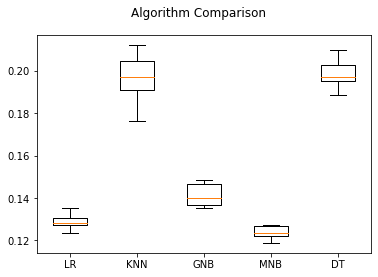

In [138]:
# Compare Algorithms - Length of cleaned reviews - cross-validation (kfold=10)

# Data
X2 = data[["Length_Clean_review"]]
y=data.Rating

# prepare configuration for cross validation test harness

# prepare models
models = []
models.append(('LR', LogisticRegression(multi_class='multinomial',solver='newton-cg')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('DT', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True)
    cv_results = cross_val_score(model, X2, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

The results are shown for different models. we are using f1-macro-score since imbalanced data.
Though KNN and DT  have performed better as # compared to Log-reg, GNB and MNB
the macro-f1-score is very low 

## Support Vector Machine

Accuracy score :  0.4496252396723026
F1 macro score :  0.1299914579429822
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       782
           2       0.00      0.00      0.00       998
           3       0.00      0.00      0.00      1208
           4       0.34      0.02      0.03      3337
           5       0.45      0.99      0.62      5149

    accuracy                           0.45     11474
   macro avg       0.16      0.20      0.13     11474
weighted avg       0.30      0.45      0.29     11474



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.44858835831300103
F1 macro score :  0.12798355135061326
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       302
           4       0.33      0.01      0.02       835
           5       0.45      0.99      0.62      1287

    accuracy                           0.45      2869
   macro avg       0.16      0.20      0.13      2869
weighted avg       0.30      0.45      0.28      2869



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


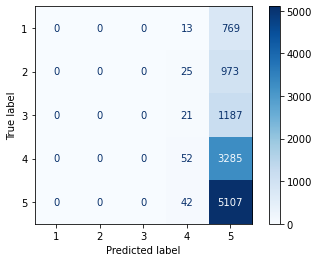

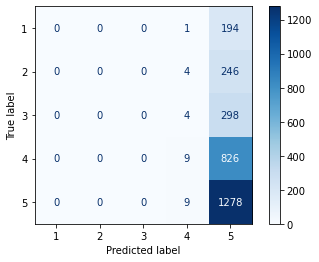

In [180]:

from sklearn.svm import SVC
model_svm = SVC(random_state=123)
model_svm.fit(X_train2,y_train2)

y_pred_train = model_svm.predict(X_train2)
print("Accuracy score : ",accuracy_score(y_train2,y_pred_train))
print("F1 macro score : ",f1_score(y_train2,y_pred_train, average='macro'))
print(classification_report(y_train2,y_pred_train))

y_pred_test = model_svm.predict(X_test2)
print("Accuracy score : ",accuracy_score(y_test2,y_pred_test))
print("F1 macro score : ",f1_score(y_test2,y_pred_test, average='macro'))
print(classification_report(y_test2,y_pred_test))

plot_confusion_matrix(model_svm,X_train2, y_train2, cmap=plt.cm.Blues)
plot_confusion_matrix(model_svm,X_test2, y_test2, cmap=plt.cm.Blues);plt.show();


The SVM model on Length of cleaned reviews  
Accuracy score is low 45% and f1-macro-score is only 13%.  
Ratings-1,2,3 have zero recall 

## Using Sentiment Analysis to Classify the RATINGS 
### Polarity and Subjectivity of original-reviews and cleaned-reviews

### Creating X and y and splitting the dataset 

In [139]:
data_blob.head(3)

ID                                             Review  \
0   0  exceptional service nice all-around daughter s...   
1   1  beautiful relaxing jw marriott desert ridge re...   
2   2  great location great location 5 mins subway ta...   

                                        Clean_review  Rating  Polarity_rev  \
0  exceptional service nice around daughter staye...       5      0.375567   
1  beautiful relaxing jw marriott desert ridge re...       5      0.584206   
2  great location great location min subway take ...       5      0.370370   

   Subjectivity_rev  Polarity_cleanRev  Subjectivity_cleanRev  
0          0.675850           0.377948               0.697279  
1          0.832460           0.584206               0.832460  
2          0.535185           0.392157               0.566667

In [140]:
X3 = data_blob[["Polarity_rev", "Subjectivity_rev"]]
X4 = data_blob[["Polarity_cleanRev","Subjectivity_cleanRev"]]
y=data_blob.Rating
X3.shape ; X4.shape ; y.shape
X3.head(3);y.head(3); X4.head(3)

(14343, 2)

(14343, 2)

(14343,)

Polarity_rev  Subjectivity_rev
0      0.375567          0.675850
1      0.584206          0.832460
2      0.370370          0.535185

0    5
1    5
2    5
Name: Rating, dtype: int64

Polarity_cleanRev  Subjectivity_cleanRev
0           0.377948               0.697279
1           0.584206               0.832460
2           0.392157               0.566667

In [141]:
# Splitting into Train and Test data (80:20)

# Reviews - Sentiments
X_train1,X_test1,y_train1,y_test1 = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123) 
X_train1.shape ; X_test1.shape

# Clean_reviews - Sentiments
X_train2,X_test2,y_train2,y_test2 = train_test_split(X4, y, test_size=0.2, stratify=y, random_state=123) 
X_train2.shape ; X_test2.shape

(11474, 2)

(2869, 2)

(11474, 2)

(2869, 2)

###  Logistic Regression on Sentiment of Original Reviews - Model on  full X3 data 

Accuracy score: 0.5231123195984104
F1-score-macro: 0.37439483072372504
              precision    recall  f1-score   support

           1       0.61      0.53      0.57       977
           2       0.37      0.33      0.35      1248
           3       0.00      0.00      0.00      1510
           4       0.34      0.20      0.25      4172
           5       0.58      0.89      0.70      6436

    accuracy                           0.52     14343
   macro avg       0.38      0.39      0.37     14343
weighted avg       0.43      0.52      0.46     14343



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


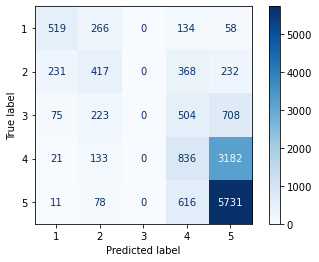

In [148]:
model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X3,y)

# for training data
y_pred_train = model_log.predict(X3)

print('Accuracy score:',accuracy_score(y,y_pred_train))
print("F1-score-macro:",f1_score(y,y_pred_train, average='macro'))

print(classification_report(y,y_pred_train))
plot_confusion_matrix(model_log, X3, y, cmap=plt.cm.Blues);plt.show();

Though accuracy is 52%, f1-macro-score is just 37%. Rating-3 recall is 0%
f1-score-macro gives equal importance to all classes irrespective of their individual proportion

In [158]:
import statistics
statistics.mean([0.57,0.35,0,0.25,0.7]) # mean of individual f1-scores gives macro-f1-score

0.374

###  Logistic Regression on Sentiment of Clean Reviews - Model on  full X4 data 

Accuracy score: 0.5214390294917381
F1-score-macro: 0.3702802025429083
              precision    recall  f1-score   support

           1       0.60      0.53      0.56       977
           2       0.37      0.32      0.34      1248
           3       0.00      0.00      0.00      1510
           4       0.33      0.20      0.25      4172
           5       0.58      0.89      0.70      6436

    accuracy                           0.52     14343
   macro avg       0.37      0.39      0.37     14343
weighted avg       0.43      0.52      0.46     14343



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


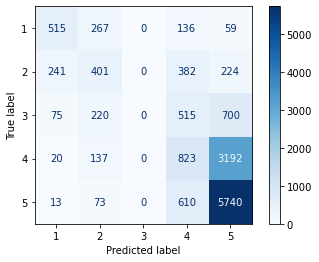

In [159]:
model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X4,y)

# for training data
y_pred_train = model_log.predict(X4)

print('Accuracy score:',accuracy_score(y,y_pred_train))
print("F1-score-macro:",f1_score(y,y_pred_train, average='macro'))

print(classification_report(y,y_pred_train))
plot_confusion_matrix(model_log, X4, y, cmap=plt.cm.Blues);plt.show();

###  Logistic Regression - Cross validation on Sentiments of Reviews (full X3 data)
### and Sentiments of clean_review (full X3 data)

In [160]:
# logistic regression on length_clean_rev - full data - cross validation (kfold=10)
kfold = KFold(n_splits=10, shuffle=True)
scoring = "f1_macro"

results_X1 = cross_val_score(LogisticRegression(random_state=123,multi_class='multinomial',
                                             solver='newton-cg'), X3, y, cv=kfold,scoring=scoring)
print("F1-macro score for sentiments on reviews: %.2f%% (%.2f%%)" % (results_X1.mean()*100, results_X1.std()*100)) 



results_X2 = cross_val_score(LogisticRegression(random_state=123,multi_class='multinomial',
                                             solver='newton-cg'), X4, y, cv=kfold,scoring=scoring)
print("F1-macro score for Sentiments of clean_reviews: %.2f%% (%.2f%%)" % (results_X2.mean()*100, results_X2.std()*100)) 

# F1-macro score for Length_reviews: 13.08% (0.31%)
# F1-macro score for Length_clean_reviews: 12.89% (0.36%)

F1-macro score for sentiments on reviews: 37.28% (1.25%)
F1-macro score for Sentiments of clean_reviews: 36.94% (1.25%)


F1-macro score is very less for both , only about 37%

###  Logistic Regression on Sentiments of  cleaned Reviews - X4 data split (80:20)
### Running different Log-reg Models using different Solvers

In [161]:
X_train2.head(3)

Polarity_cleanRev  Subjectivity_cleanRev
4953            0.576786               0.672619
12047           0.421000               0.689000
12170           0.512500               0.841667

In [162]:
# prepare Log-reg models with different solvers
models = []
models.append(('LR_newton_cg', LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')))
models.append(('LR_saga', LogisticRegression(random_state=123, multi_class='multinomial',solver='saga')))
models.append(('LR_sag', LogisticRegression(random_state=123, multi_class='multinomial',solver='sag')))
models.append(('LR_lbfgs', LogisticRegression(random_state=123, multi_class='multinomial',solver='lbfgs')))

# evaluate each model in turn
accuracy_train = []
f1_score_train= []
accuracy_test = []
f1_score_test = []
names = []
for name, model in models:
    model.fit(X_train2,y_train2)
    y_pred_train2 = model.predict(X_train2)
    accuracy_train2 = accuracy_score(y_train2,y_pred_train2)
    f1_score_macro_train2 = f1_score(y_train2,y_pred_train2,average='macro')
    
    y_pred_test2 = model.predict(X_test2)
    accuracy_test2 = accuracy_score(y_test2,y_pred_test2)
    f1_score_macro_test2 = f1_score(y_test2,y_pred_test2,average='macro')
    
    names.append(name)
    accuracy_train.append(accuracy_train2)
    f1_score_train.append(f1_score_macro_train2)
    accuracy_test.append(accuracy_test2)
    f1_score_test.append(f1_score_macro_test2)
    
    msg = "%s: %f (%f) %f (%f)" % (name, accuracy_train2, f1_score_macro_train2,accuracy_test2,f1_score_macro_test2)
    print(msg)

# poor models when use sentiments of clean_reviews . 
# low accuracy (52%) and f1-macro-score(37%) for both train and test data

LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

LR_newton_cg: 0.522660 (0.371753) 0.520739 (0.368065)


LogisticRegression(multi_class='multinomial', random_state=123, solver='saga')

LR_saga: 0.522660 (0.371753) 0.520739 (0.368065)


LogisticRegression(multi_class='multinomial', random_state=123, solver='sag')

LR_sag: 0.522486 (0.371603) 0.520390 (0.367758)


LogisticRegression(multi_class='multinomial', random_state=123)

LR_lbfgs: 0.522660 (0.371753) 0.520739 (0.368065)


### Running Many different Models on Sentiments of cleaned reviews - full data (X4)
### Cross-validation (kfold=10)

LR: 0.367161 (0.015738)
KNN: 0.387494 (0.011219)
GNB: 0.388267 (0.016250)
MNB: nan (nan)


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 641, in fit
    self._count(X, Y)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 763, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1046, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
C:\Users\Admin\Anaconda3\lib\site-package

DT: 0.342233 (0.011979)


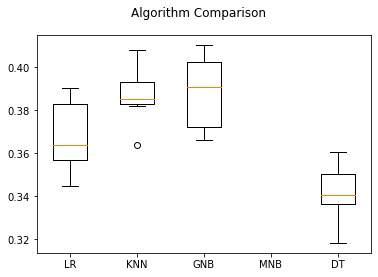

In [173]:
# Compare Algorithms - Sentiments of cleaned reviews - cross-validation (kfold=10), KNN(n_neighbors=11)

# Data
X4 = data_blob[["Polarity_cleanRev","Subjectivity_cleanRev"]]
y=data_blob.Rating

# prepare configuration for cross validation test 

# prepare models
models = []
models.append(('LR', LogisticRegression(multi_class='multinomial',solver='newton-cg')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=11)))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('DT', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True)
    cv_results = cross_val_score(model, X4, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

The results are shown for different models. 
MNB no output as polarity has negative values,ranges from -1 to +1
the macro-f1-score is very low for all models

## Using Polarity of Clean Reviews to Classify the RATINGS 

### Creating X and y and splitting the dataset 

In [166]:
data_blob.head(3)

ID                                             Review  \
0   0  exceptional service nice all-around daughter s...   
1   1  beautiful relaxing jw marriott desert ridge re...   
2   2  great location great location 5 mins subway ta...   

                                        Clean_review  Rating  Polarity_rev  \
0  exceptional service nice around daughter staye...       5      0.375567   
1  beautiful relaxing jw marriott desert ridge re...       5      0.584206   
2  great location great location min subway take ...       5      0.370370   

   Subjectivity_rev  Polarity_cleanRev  Subjectivity_cleanRev  
0          0.675850           0.377948               0.697279  
1          0.832460           0.584206               0.832460  
2          0.535185           0.392157               0.566667

In [167]:
X5 = data_blob[["Polarity_cleanRev"]]
X6 = data_blob[["Subjectivity_cleanRev"]]
y=data_blob.Rating
X5.shape ; X6.shape ; y.shape
X5.head(3);y.head(3); X6.head(3)

(14343, 1)

(14343, 1)

(14343,)

Polarity_cleanRev
0           0.377948
1           0.584206
2           0.392157

0    5
1    5
2    5
Name: Rating, dtype: int64

Subjectivity_cleanRev
0               0.697279
1               0.832460
2               0.566667

In [168]:
# Splitting into Train and Test data (80:20)

# Clean_reviews - Polarity
X_train1,X_test1,y_train1,y_test1 = train_test_split(X5, y, test_size=0.2, stratify=y, random_state=123) 
X_train1.shape ; X_test1.shape

# Clean_reviews - Subjectivity
X_train2,X_test2,y_train2,y_test2 = train_test_split(X6, y, test_size=0.2, stratify=y, random_state=123) 
X_train2.shape ; X_test2.shape

(11474, 1)

(2869, 1)

(11474, 1)

(2869, 1)

###  Logistic Regression on Polarity of Clean Reviews - Model on  full X5 data 

In [169]:
model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X5,y)

# for training data
y_pred_train = model_log.predict(X5)

print('Accuracy score:',accuracy_score(y,y_pred_train))
print("F1-score-macro:",f1_score(y,y_pred_train, average='macro'))

print(classification_report(y,y_pred_train))
plot_confusion_matrix(model_log, X5, y, cmap=plt.cm.Blues);plt.show();

Accuracy score: 0.5219270724395175
F1-score-macro: 0.3699162439242601
              precision    recall  f1-score   support

           1       0.59      0.53      0.56       977
           2       0.36      0.32      0.34      1248
           3       0.00      0.00      0.00      1510
           4       0.34      0.20      0.25      4172
           5       0.58      0.89      0.70      6436

    accuracy                           0.52     14343
   macro avg       0.37      0.39      0.37     14343
weighted avg       0.43      0.52      0.45     14343



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For logistic regression model using Polarity scores only on cleaned_reviews -
Though accuracy is 52%, f1-macro-score is just 37%. Rating-3 recall is 0%

###  Logistic Regression on Subjectivity of Clean Reviews - Model on  full X6 data 

Accuracy score: 0.4487903506937182
F1-score-macro: 0.14936917346562525
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       977
           2       0.32      0.01      0.02      1248
           3       0.00      0.00      0.00      1510
           4       0.26      0.06      0.10      4172
           5       0.46      0.96      0.63      6436

    accuracy                           0.45     14343
   macro avg       0.21      0.21      0.15     14343
weighted avg       0.31      0.45      0.31     14343



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


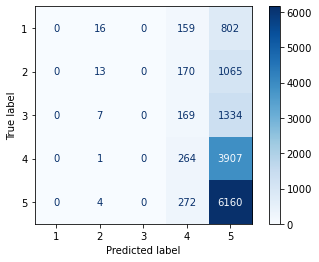

In [170]:
model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X6,y)

# for training data
y_pred_train = model_log.predict(X6)

print('Accuracy score:',accuracy_score(y,y_pred_train))
print("F1-score-macro:",f1_score(y,y_pred_train, average='macro'))

print(classification_report(y,y_pred_train))
plot_confusion_matrix(model_log, X6, y, cmap=plt.cm.Blues);plt.show();

For logistic regression model using Subjectivity scores only on cleaned_reviews - 
accuracy has further been reduced to 45%, f1-macro-score is just 15%. Rating-1 and 3 recall is 0%

when used polarity scores on cleaned reviews, log-reg model gave accuracy of 52% and f1-macro-score
was 37%. only for rating-1, recall was 0%. for rating-3, recall was 53% and f1-score was 56%

### Running different Models on Polarity of cleaned reviews - full data (X5)
### Cross-validation (kfold=10)

LR: 0.368195 (0.009719)
KNN: 0.394029 (0.008107)
GNB: 0.371788 (0.014933)
DT: 0.338808 (0.013171)


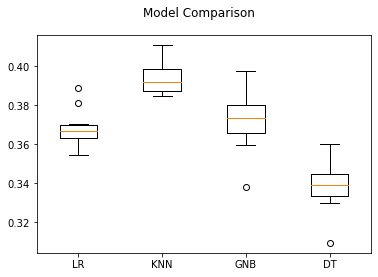

In [174]:
# Compare Algorithms - Polarity of cleaned reviews - cross-validation (kfold=10) , KNN(n_neighbors=5)

# Data
X5 = data_blob[["Polarity_cleanRev"]]
y=data_blob.Rating

# prepare configuration for cross validation test 

# prepare models
models = []
models.append(('LR', LogisticRegression(multi_class='multinomial',solver='newton-cg')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=11)))
models.append(('GNB', GaussianNB()))
# models.append(('MNB', MultinomialNB()))
models.append(('DT', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True)
    cv_results = cross_val_score(model, X5, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

The results are shown for different models. 
The f1-score is between 30 to 40%. 

### Running different Models on Subjectivity of cleaned reviews - full data (X6)
### Cross-validation (kfold=10)

In [176]:
X6.head(3)

Subjectivity_cleanRev
0               0.697279
1               0.832460
2               0.566667

LR: 0.148819 (0.006001)
KNN: 0.220086 (0.013706)
GNB: 0.139849 (0.007247)
DT: 0.221871 (0.014267)


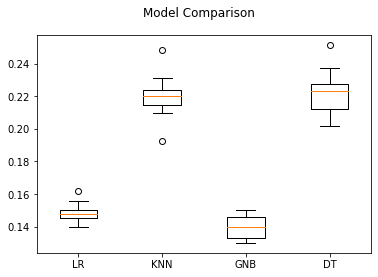

In [177]:
# Compare Algorithms - Subjectivity of cleaned reviews - cross-validation (kfold=10) , KNN(n_neighbors=5)

# Data
X6 = data_blob[["Subjectivity_cleanRev"]]
y=data_blob.Rating

# prepare configuration for cross validation test 

# prepare models
models = []
models.append(('LR', LogisticRegression(multi_class='multinomial',solver='newton-cg')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=11)))
models.append(('GNB', GaussianNB()))
# models.append(('MNB', MultinomialNB()))
models.append(('DT', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True)
    cv_results = cross_val_score(model, X6, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

The results are shown for different models for subjectivity of cleaned reviews. 
The f1-score-macro  for subjectivity is lower than that of polarity  

### Running SVM Model on Polarity of cleaned reviews - full data (X5)
### Cross-validation (kfold=10)

In [182]:
# SVM on Polarity of cleaned reviews  - full data(X5) - cross validation (kfold=10)
kfold = KFold(n_splits=10, shuffle=True)
scoring = "f1_macro"

results_X1 = cross_val_score(SVC(random_state=123), X5, y, cv=kfold,scoring=scoring)
print("F1-macro score for polarity on cleaned reviews: %.2f%% (%.2f%%)" % (results_X1.mean()*100, results_X1.std()*100)) 


F1-macro score for polarity on cleaned reviews: 37.07% (1.39%)


SVM model on polarity of cleaned review - f1-macro score is 37%

## Random Forest on Polarity of cleaned reviews

Accuracy score :  0.4496252396723026
F1 macro score :  0.1299914579429822
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       782
           2       0.00      0.00      0.00       998
           3       0.00      0.00      0.00      1208
           4       0.34      0.02      0.03      3337
           5       0.45      0.99      0.62      5149

    accuracy                           0.45     11474
   macro avg       0.16      0.20      0.13     11474
weighted avg       0.30      0.45      0.29     11474



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.44858835831300103
F1 macro score :  0.12798355135061326
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       302
           4       0.33      0.01      0.02       835
           5       0.45      0.99      0.62      1287

    accuracy                           0.45      2869
   macro avg       0.16      0.20      0.13      2869
weighted avg       0.30      0.45      0.28      2869



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


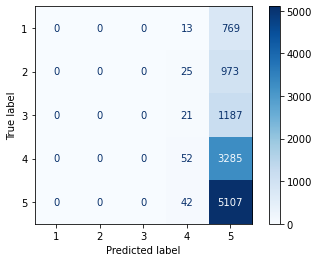

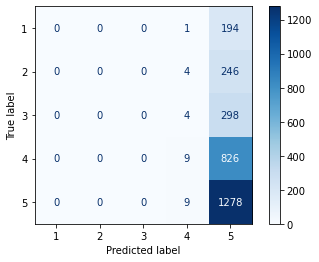

In [183]:
# Random forest - takes 10-20 mins

model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000, criterion='entropy', random_state=123)
model_rf.fit(X_train2, y_train2)

y_pred_train = model_svm.predict(X_train2)
print("Accuracy score : ",accuracy_score(y_train2,y_pred_train))
print("F1 macro score : ",f1_score(y_train2,y_pred_train, average='macro'))
print(classification_report(y_train2,y_pred_train))

y_pred_test = model_svm.predict(X_test2)
print("Accuracy score : ",accuracy_score(y_test2,y_pred_test))
print("F1 macro score : ",f1_score(y_test2,y_pred_test, average='macro'))
print(classification_report(y_test2,y_pred_test))

plot_confusion_matrix(model_svm,X_train2, y_train2, cmap=plt.cm.Blues)
plot_confusion_matrix(model_svm,X_test2, y_test2, cmap=plt.cm.Blues);plt.show();

Random forest model on polarity of cleaned review - accuracy is 45% and f1-macro score is 13%     
ratings-1,2,3 -  0% correct classification

1. We have done EDA   
contractions replaced ( replacing n't  and 'nt  by not)   
removing word 'not' from list of stopwords

2. Length of original reviews and Length of clean_reviews   
Have run different models   
Logistic Regression, KNN, Decision Trees, Gaussian Naive Bayes, Multinomial  Naive Bayes   
accuracy and f1-macro-scores were very poor

3. Sentiments using TextBlob - polarity and subjectivity   
Have run models using both as well as separately, poor accuracy and f1-macro-scores 
for subjectivity scores were still lesser as compared to that of polarity  

We have also run Random forest and SVM on polarity, but poor results

4. cross-validation with number of folds (10)    
Since data is imbalanced , we have run using  cross-validation and found out f1-macro-scores
for all. 

5. The results (accuracy and f1-macro scores)  have been very poor,   
when we run various models using length and sentiments of reviews (original and cleaned)   

Previously we have run various models on tf-binary, tf and tfidf 
Next we will run models combining those term-vectors with length and sentiments and check the results
